Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a model available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Literary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for literary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelty of British women publishing novels during the early 19th century. 

Can we help close a literary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning algorithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

unable to import 'smart_open.gcs', disabling that module


In [2]:
gensim.__version__

'3.8.1'

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chunks

In [3]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [4]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [5]:
import os

def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [6]:
tokens = gather_data(path)

In [7]:
tokens[0][0:10]

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich']

In [8]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

## Follow Along

In [9]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [10]:
len(titles)

813

In [11]:
len(tokens)

813

### Author DataFrame


In [12]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [13]:
df.head()

,tokens
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo..."
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p..."
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be..."
Austen_Emma0003,"[native, highbury, born, respectable, family, ..."
Austen_Emma0004,"[mention, handsome, letter, weston, received, ..."


In [14]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [15]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [16]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [17]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our function. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this function later on. 

In [18]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(text)
                yield tokens

In [19]:
streaming_data = doc_stream(path)

In [20]:
type(streaming_data)

generator

In [21]:
# gather_data => returns a list
# doc_stream => returns a generator

In [22]:
next(streaming_data) # Returns one document at a time from the generator

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich',
 'comfortable',
 'home',
 'happy',
 'disposition',
 'unite',
 'best',
 'blessings',
 'existence',
 'lived',
 'nearly',
 'years',
 'world',
 'little',
 'distress',
 'vex',
 'youngest',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period',
 'mother',
 'died',
 'long',
 'ago',
 'indistinct',
 'remembrance',
 'caresses',
 'place',
 'supplied',
 'excellent',
 'woman',
 'governess',
 'fallen',
 'little',
 'short',
 'mother',
 'affection',
 'sixteen',
 'years',
 'miss',
 'taylor',
 'woodhouse',
 'family',
 'governess',
 'friend',
 'fond',
 'daughters',
 'particularly',
 'emma',
 'intimacy',
 'sisters',
 'miss',
 'taylor',
 'ceased',
 'hold',
 'nominal',
 'office',
 'governess',
 'mildness',
 'temper',
 'hardly',
 'allowed',
 'impose',
 'restraint',
 'shadow',
 'authority',
 'long',
 'passed',
 'away',


### Gensim LDA Topic Modeling

In [23]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [24]:
id2word.token2id['england']

3986

In [25]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2753, 1), (3986, 3), (6601, 1), (6818, 1)]

In [26]:
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(tokens))

56
7056


In [27]:
len(id2word.keys())

22095

In [30]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=2, no_above=0.95)

In [31]:
len(id2word.keys())

8102

In [32]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [33]:
corpus[345][:10]

[(0, 1),
 (2, 1),
 (11, 1),
 (21, 2),
 (32, 1),
 (34, 1),
 (35, 1),
 (37, 1),
 (53, 1),
 (54, 1)]

In [34]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=12
                  )

In [35]:
lda.print_topics()

[(0,
  '0.016*"harriet" + 0.015*"emma" + 0.009*"weston" + 0.008*"elton" + 0.008*"good" + 0.008*"think" + 0.008*"man" + 0.007*"miss" + 0.007*"knightley" + 0.006*"know"'),
 (1,
  '0.006*"like" + 0.006*"sir" + 0.006*"jane" + 0.006*"thought" + 0.005*"little" + 0.005*"good" + 0.005*"love" + 0.004*"old" + 0.004*"poor" + 0.004*"man"'),
 (2,
  '0.011*"elinor" + 0.009*"marianne" + 0.008*"elizabeth" + 0.007*"sister" + 0.007*"miss" + 0.005*"time" + 0.005*"darcy" + 0.005*"mother" + 0.005*"soon" + 0.005*"lady"'),
 (3,
  '0.005*"hand" + 0.005*"eyes" + 0.005*"john" + 0.004*"like" + 0.004*"saw" + 0.004*"asked" + 0.004*"little" + 0.003*"time" + 0.003*"know" + 0.003*"sir"'),
 (4,
  '0.014*"miss" + 0.011*"jane" + 0.008*"emma" + 0.008*"know" + 0.007*"thing" + 0.007*"think" + 0.006*"good" + 0.006*"little" + 0.006*"shall" + 0.006*"dear"'),
 (5,
  '0.007*"jane" + 0.006*"elizabeth" + 0.006*"darcy" + 0.006*"know" + 0.005*"wickham" + 0.005*"think" + 0.004*"miss" + 0.004*"good" + 0.004*"love" + 0.004*"letter"'),

In [36]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [37]:
topics = [' '.join(t[0:5]) for t in words]

In [38]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
harriet emma weston elton good

------ Topic 1 ------
like sir jane thought little

------ Topic 2 ------
elinor marianne elizabeth sister miss

------ Topic 3 ------
hand eyes john like saw

------ Topic 4 ------
miss jane emma know thing

------ Topic 5 ------
jane elizabeth darcy know wickham

------ Topic 6 ------
hunsden miss helen temple bread

------ Topic 7 ------
little madame like monsieur vous

------ Topic 8 ------
burns thought like scatcherd miss

------ Topic 9 ------
man bennet young elizabeth collins

------ Topic 10 ------
like little thought long good

------ Topic 11 ------
emma miss knightley harriet thing

------ Topic 12 ------
bretton know dr little lucy

------ Topic 13 ------
thousand mason like know sisters

------ Topic 14 ------
lydia mother wickham father uncle



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [39]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [40]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.086109  0.006008       1        1  41.976704
2     -0.096107 -0.014838       2        1  19.396441
4     -0.069379  0.064266       3        1  11.418566
7      0.123732  0.057420       4        1   8.034663
0     -0.113208  0.084783       5        1   4.911795
11    -0.103097  0.091143       6        1   4.028003
5     -0.114385 -0.018411       7        1   3.994246
14    -0.103919 -0.106250       8        1   1.489619
1      0.011589 -0.029207       9        1   1.013517
8      0.097039  0.021387      10        1   0.999440
3      0.142886 -0.006040      11        1   0.770558
9     -0.073179 -0.104524      12        1   0.767084
12     0.028002  0.056611      13        1   0.646022
6      0.102658 -0.024924      14        1   0.297365
13     0.081258 -0.077425      15        1   0.255976, topic_info=       Term         Freq        Total Category  logprob  loglift
403    like  1327.000000  1327.000000  Default  30.0000  30.0000
159  little  1716.000000  1716.000000  Default  29.0000  29.0000
183    miss  1508.000000  1508.000000  Default  28.0000  28.0000
399    know  1421.000000  1421.000000  Default  27.0000  27.0000
86     emma   819.000000   819.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
148    jane     1.964192   907.805542  Topic15  -6.0124  -0.1681
856   heard     1.899378   621.640198  Topic15  -6.0460   0.1770
260    soon     1.874974   922.447754  Topic15  -6.0589  -0.2306
135   house     1.863696   758.746460  Topic15  -6.0649  -0.0413
356   doubt     1.821970   313.732605  Topic15  -6.0876   0.8192

[1129 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7784      1  0.737192  abandon
7784     15  0.184298  abandon
792       3  0.230587    abbey
792       5  0.658820    abbey
792       6  0.098823    abbey
...     ...       ...      ...
611      12  0.024409    young
611      13  0.009154    young
611      14  0.001526    young
8084      1  0.113948    zelie
8084      4  0.854609    zelie

[4298 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 5, 8, 1, 12, 6, 15, 2, 9, 4, 10, 13, 7, 14])

### Overall Model / Documents

In [41]:
lda[corpus[0]]

[(2, 0.23459414), (11, 0.7633983)]

In [42]:
distro = [lda[d] for d in corpus]

In [43]:
distro[0]

[(2, 0.23459637), (11, 0.763396)]

In [44]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [45]:
len(new_distro)

813

In [46]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [47]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [48]:
df.head()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle,author
Austen_Emma0000,0.000000,0.0,0.234599,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.763394,0.000000,0.0,0.0,Austen
Austen_Emma0001,0.339853,0.0,0.000000,0.0,0.427913,0.000000,0.0,0.0,0.0,0.0,0.0,0.229980,0.000000,0.0,0.0,Austen
Austen_Emma0002,0.669727,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.328009,0.000000,0.0,0.0,Austen
Austen_Emma0003,0.191078,0.0,0.000000,0.0,0.000000,0.806792,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,Austen
Austen_Emma0004,0.485058,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.106300,0.406793,0.0,0.0,Austen


In [49]:
df.groupby('author').mean()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle
author,,,,,,,,,,,,,,,
Austen,0.103918,0.006973,0.428128,0.000000,0.211957,0.088507,0.000000,0.000291,0.001807,0.017822,0.013380,0.086613,0.004561,0.000028,0.033301
CBronte,0.003945,0.012633,0.008016,0.013694,0.036295,0.003886,0.005369,0.137135,0.015776,0.000056,0.746322,0.001341,0.007101,0.004740,0.001020


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text preprocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [50]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [52]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=7)

In [53]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [54]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-0.610310
1,0,4,-0.653974
2,0,6,-0.790511
3,0,8,-0.676546
4,0,10,-0.794004


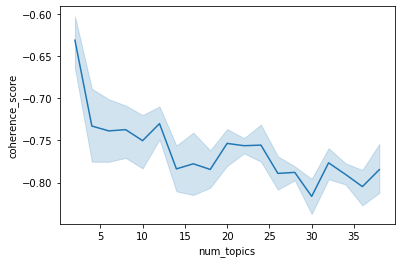

In [55]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [ ]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)